<a href="https://colab.research.google.com/github/olumideaeo/Machine-Learning-Collection/blob/master/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 49.5 MB/s 
     |████████████████████████████████| 182 kB 46.4 MB/s 


In [33]:
import numpy as np 
import pandas as pd 
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import LSTM, GRU, SimpleRNN
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tqdm import tqdm

In [12]:
# importing the dataset 
df_raw=pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/rawtext.txt')
df_train = pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/Train_Kanglish.csv')
df_test = pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/Test_withoutLabels_Kanglish.csv')


In [13]:
df_raw

,text
0,klm
1,movie nalli continuation illa
2,nijavagalu super guru
3,concept making camera work yalha changi but ma...
4,nice but voice yar act madidaro avr atrane dub...
...,...
72129,dandapinda charche ivra mane
72130,siddaramaiah boss fan
72131,power boss fan
72132,aasthi koti madoke farmer name politicians


In [14]:
df_train

,word,tag
0,anusthu,kn
1,woww,en
2,staying,en
3,near,en
4,hostel,en
...,...,...
14842,hiremadtara,en-kn
14843,solutionila,en-kn
14844,accessmadkoli,en-kn
14845,glasshakisi,en-kn


In [15]:
df_test

,word
0,alla
1,kopista
2,baruthe
3,coolagiru
4,madhuswamy
...,...
4580,kalena
4581,horg
4582,tarovanthaa
4583,banglore


In [16]:
df_train.iloc[:,-1:]

,tag
0,kn
1,en
2,en
3,en
4,en
...,...
14842,en-kn
14843,en-kn
14844,en-kn
14845,en-kn


In [17]:
df_train['tag'].value_counts()

kn          6526
en          4469
other       1663
en-kn       1379
name         708
location     102
Name: tag, dtype: int64

In [18]:
df_train.drop_duplicates(inplace = True, keep = 'first')

In [19]:
df_train.describe(include = 'all')

,word,tag
count,14769,14769
unique,14762,6
top,mindalli,kn
freq,2,6494


Text(0.5, 1.0, 'Distribution of tags in dataset')

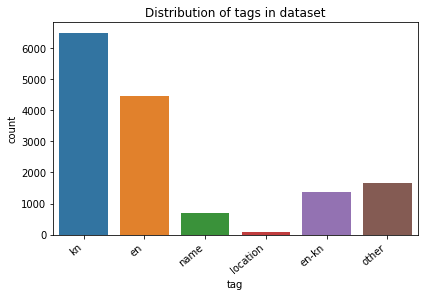

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.countplot(data = df_train, x = 'tag')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.rcParams["figure.figsize"] = (15, 8)
plt.tight_layout()
plt.title('Distribution of tags in dataset')

In [26]:
sent_to_id  = {"kn":0, "en":1,"en-kn":2,"name":3,"location":4,"other":5}

In [27]:
df_train["sentiment_id"] = df_train['tag'].map(sent_to_id)

In [28]:
df_train

,word,tag,sentiment_id
0,anusthu,kn,0
1,woww,en,1
2,staying,en,1
3,near,en,1
4,hostel,en,1
...,...,...,...
14842,hiremadtara,en-kn,2
14843,solutionila,en-kn,2
14844,accessmadkoli,en-kn,2
14845,glasshakisi,en-kn,2


In [43]:
#Roberta base model
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

def build_model(transformer, max_len=160):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(13, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [44]:
AUTO = tf.data.experimental.AUTOTUNE
MODEL = 'roberta-base'

In [45]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [47]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df_train.sentiment_id)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_train.word,Y, test_size=0.2, shuffle=True)

In [51]:
X_train_t = regular_encode(X_train, tokenizer, maxlen=max_len)
X_test_t = regular_encode(X_test, tokenizer, maxlen=max_len)

TypeError: ignored